# ATV 05 - Random Search

## Imports e Divisão train/test

In [59]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import keras_tuner

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import numpy as np
import random

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

tf.config.list_physical_devices('GPU')

[]

In [60]:
(X_all, y_all), (X_test, y_test) = mnist.load_data()
X_all.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [61]:
X_train = X_all[10000:]
X_valid = X_all[:10000]

y_train = y_all[10000:]
y_valid = y_all[:10000]

type(X_test)

numpy.ndarray

## Visualizando algumas imagens da base

Imagens 28x28 de ints representando a escala de cinza de 0 (preto) a 255 (branco)

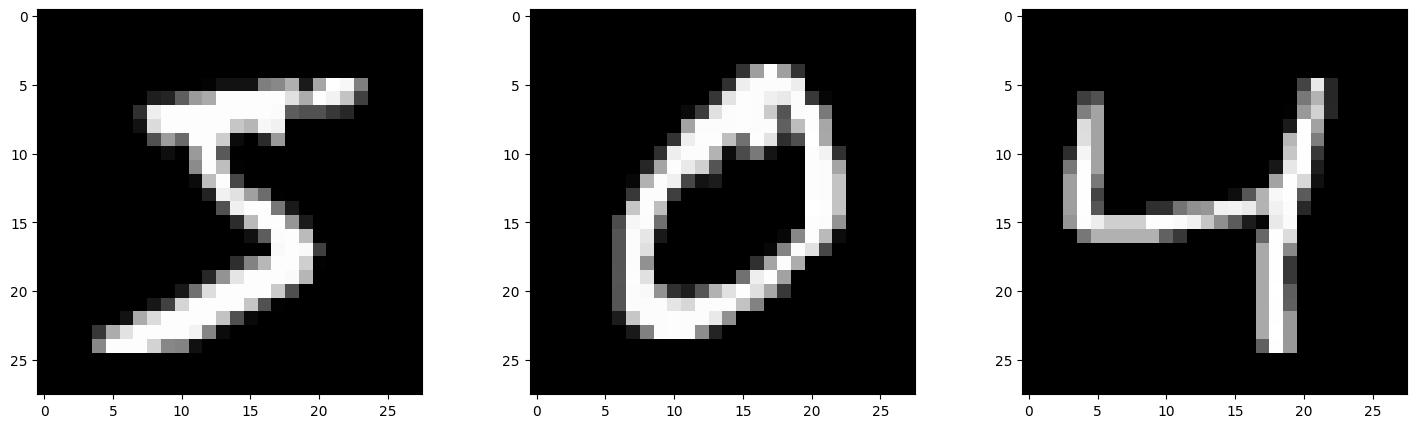

In [62]:
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis(True)
    plt.imshow(X_all[i], cmap='gray')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [63]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254,
        255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

## Normalização dos pixels para o range 0, 1

achatando cada linha 2D 28 x 28 em um array 1D de tamanho 784

considerar a intensidade de cada pixel como sua feature individual é uma abordagem "ingênua" e simplória porem suficiente para esse caso. 

In [64]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_test = X_test.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], 28 * 28))
X_valid = X_valid.astype("float32") / 255

## Encoding da saída

A camada de saída terá 10 neurônios representando os caracteres de 0 a 9, e cada um terá como saída a probabilidade de ser cada um. Para isso é necessário colocar como entrada da classe real um vetor da classe one-hot encoded, em que por tabela cada index representa a probabilidade de ser cada caracter

In [65]:
y_train[:10]

array([3, 8, 7, 9, 9, 0, 1, 1, 5, 2], dtype=uint8)

In [66]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)
y_train[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [67]:
def download_mnist_and_preprocess():

    # download and holdout
    (X_all, y_all), (X_test, y_test) = mnist.load_data()
    
    X_train = X_all[10000:]
    X_valid = X_all[:10000]

    y_train = y_all[10000:]
    y_valid = y_all[:10000]

    # normalize pixels to [0, 1] range
    X_train = X_train.reshape((X_train.shape[0], 28 * 28))
    X_train = X_train.astype("float32") / 255

    X_test = X_test.reshape((X_test.shape[0], 28 * 28))
    X_test = X_test.astype("float32") / 255

    X_valid = X_valid.reshape((X_valid.shape[0], 28 * 28))
    X_valid = X_valid.astype("float32") / 255

    # one hot encode output
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_valid = to_categorical(y_valid)

    return [(X_train, y_train), (X_valid, y_valid), (X_test, y_test)]



In [68]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True
)

## Comparando 10 iterações de Random Search para tunar os hiperparâmetros

Para cada iteração do random search, comparar performance do modelo final, plotar graficos de acc e loss de treino/val

In [69]:
train, valid, test = download_mnist_and_preprocess()

X_train, y_train = train
X_valid, y_valid = valid

In [70]:
def create_model(num_hidden_layers, neurons_per_layer, activation_func):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    for _ in range(num_hidden_layers):
        model.add(Dense(neurons_per_layer, activation=activation_func))
    
    model.add(Dense(10, activation='sigmoid'))
    
    model.compile(
        optimizer="rmsprop",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model


def build_model(hp):
    num_hidden_layers = hp.Int("num_hidden_layers", min_value=1, max_value=5, step=1)
    neurons_per_layer = hp.Choice("neurons_per_layer", [128, 200, 300, 400, 500])
    activation_func = hp.Choice("activation", ["relu", "sigmoid"])
    
    # call existing model-building code with the hyperparameter values.
    model = create_model(
        num_hidden_layers=num_hidden_layers, neurons_per_layer=neurons_per_layer, activation_func=activation_func
    )
    return model


build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=True>

In [71]:
results = []
for i in range(10):
    print(f"Running Search {i+1}")
    tuner = keras_tuner.RandomSearch(
        build_model,
        objective='val_accuracy',
        seed=RANDOM_STATE,
        directory="./",
        project_name="training/",
        overwrite=True
    )

    # Perform the search
    tuner.search(
        X_train, y_train,
        epochs=50,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping],
        batch_size=64,
        verbose=1
    )

    # Retrieve the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters {i+1}: {best_hyperparameters.values}")

    results.append({"model": best_model, "hyperparameters": best_hyperparameters})

Trial 10 Complete [00h 02m 03s]
val_accuracy: 0.9822999835014343

Best val_accuracy So Far: 0.984499990940094
Total elapsed time: 00h 13m 46s
Best hyperparameters 10: {'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}


In [72]:
for result in results:
    print(result["hyperparameters"].values)

{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 4, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}
{'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'}


Acima foi utilizado o RandomSearch do Keras 10 vezes, com 10 trials cada vez que encontrou a config {'num_hidden_layers': 2, 'neurons_per_layer': 500, 'activation': 'relu'} em TODAS as iterações. Uma análise visual enquanto o search rodava apontou que a busca não muda a ordem aleatoriamente em cada vez, ela segue um padrão, portanto, é compreensível que em 10 trials para cada uma das 10 iterações o search tenha encontrado a melhor configuração ótima.